# Cleaning up simple model

In [1]:
import numpy as np
import xarray
import matplotlib.pyplot as plt
import pandas as pd

## Load velocity cube and pick point to fit

In [2]:
fn = "/home/mchristo/proj/ms/Hubbard2024/velocity/hubbard_inversion_2015-10-01_2023-01-01.nc"
ds = xarray.load_dataset(fn)

ds["v"] = np.hypot(ds["vx"], ds["vy"])
t = ds
x = ds["x"].to_numpy()
y = ds["y"].to_numpy()

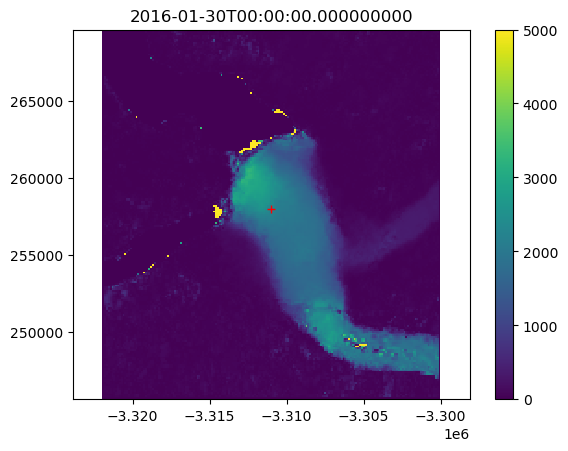

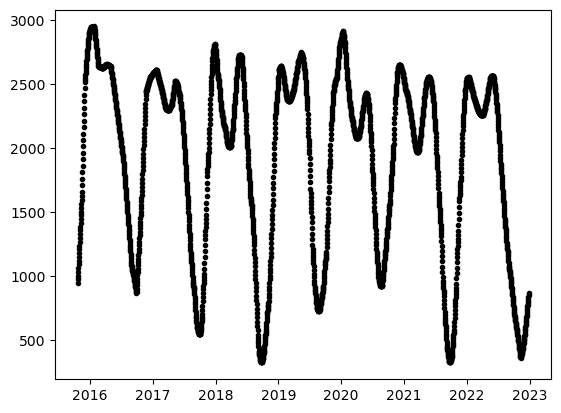

In [7]:
# choose a point for velocity
x0 = -3.311e6
y0 = 258000

obs = ds.sel(x=x0, y=y0, method="nearest")

# Interpolate to daily velocities, initialize observation xarray
obs = obs.resample(time='1D').interpolate('linear')

# Plot it
plt.pcolormesh(x,y,ds["v"][100,:,:],vmin=0,vmax=5000)
plt.axis("equal")
plt.plot(x0,y0,'r+')
plt.title(obs["time"].to_numpy()[100])
plt.colorbar()

plt.figure()
plt.plot(obs["time"], obs["v"], "k.")

## Load terminus data, add to observation xarray

In [239]:
fn = "/home/mchristo/proj/ms/Hubbard2024/terminus_change/terminus_speed_weather.csv"
df = pd.read_csv(fn)
tdf = df["Date"].apply(np.datetime64)

# Interpolate weather and terminus onto velocity times
obs["term"] = (
    "time",
    np.interp(obs["time"], tdf, df["terminus_retreat_m"], left=np.nan, right=np.nan),
)
obs["T"] = (
    "time",
    np.interp(
        obs["time"], tdf, df["AirTempC_Yakutat_smooth"], left=np.nan, right=np.nan
    ),
)

# Make detrended terminus
p = obs.polyfit("time", 1)
v = xarray.polyval(obs["time"], p["term_polyfit_coefficients"])
obs["term_detrend"] = obs["term"]-v

# Create October-Ocbtober cumulative PDD metric
obs["pdd"] = ("time", np.zeros(len(obs["time"])))

years = np.unique(obs["time"].dt.year)
years = np.append(years, years[-1] + 1)

obs["Tpos"] = obs["T"].copy()
obs["Tpos"][obs["Tpos"] < 0] = 0

for year in np.unique(obs["time"].dt.year):
    start = np.datetime64(str(year - 1) + "-10-01")
    stop = np.datetime64(str(year) + "-09-30")
    mask = np.logical_and(obs["time"] > start, obs["time"] < stop)
    obs["pdd"][mask] = np.cumsum(obs["Tpos"][mask])

# Create STA/LTA PDD metric
obs["pdd_stalta"] = obs["Tpos"].rolling(time=5).mean()/obs["Tpos"].rolling(time=120).mean()

In [256]:
# function that produces a velocity time series

def vs(x, obs):
    [term_fac, pdd_fac, term_off, pdd_off, tshift] = x

    vpdd = pdd_fac*(obs["pdd_stalta"].shift(time=int(tshift))-pdd_off)
    vterm = term_fac*(obs["term_detrend"].shift(time=int(tshift))-term_off)
    
    return vpdd, vterm



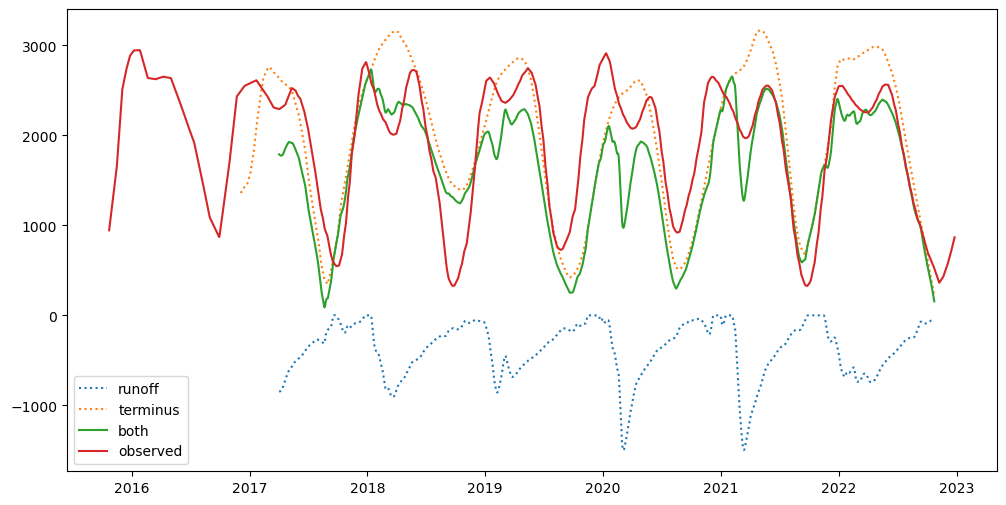

In [257]:
x0 = [-10, -300, 200, 0, -50]
vr, vterm=vs(x0, obs)

plt.figure(figsize=(12,6))
plt.plot(obs["time"], vr, ':',label='runoff')
plt.plot(obs["time"], vterm, ':', label='terminus')
plt.plot(obs["time"], vterm+vr, label='both')
plt.plot(obs["time"], obs["v"], label='observed')
plt.legend()

In [270]:
def misfit(x, obs, start=np.datetime64("2019-10-01"), stop=np.datetime64("2022-08-01")):
    vr, vterm = vs(x, obs)

    # Time bounds for fitting
    mask = np.logical_and(obs["time"] >= start, obs["time"] <= stop)
    vtot = vr+vterm

    return np.sum((obs["v"][mask].to_numpy()-vtot[mask].to_numpy())**2)
          

In [271]:
from scipy.optimize import minimize
print(misfit(x0, obs))
res = minimize(misfit, x0, args=(obs), method='Nelder-Mead', tol=1e-8, options={'maxiter':10000})
res

364259076.0580757


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 170847979.89130974
             x: [-6.898e+00 -1.404e+02  3.139e+02  1.686e-03 -5.822e+01]
           nit: 242
          nfev: 494
 final_simplex: (array([[-6.898e+00, -1.404e+02, ...,  1.686e-03,
                        -5.822e+01],
                       [-6.898e+00, -1.404e+02, ...,  1.686e-03,
                        -5.822e+01],
                       ...,
                       [-6.898e+00, -1.404e+02, ...,  1.686e-03,
                        -5.822e+01],
                       [-6.898e+00, -1.404e+02, ...,  1.686e-03,
                        -5.822e+01]]), array([ 1.708e+08,  1.708e+08,  1.708e+08,  1.708e+08,
                        1.708e+08,  1.708e+08]))

<Figure size 1200x600 with 0 Axes>

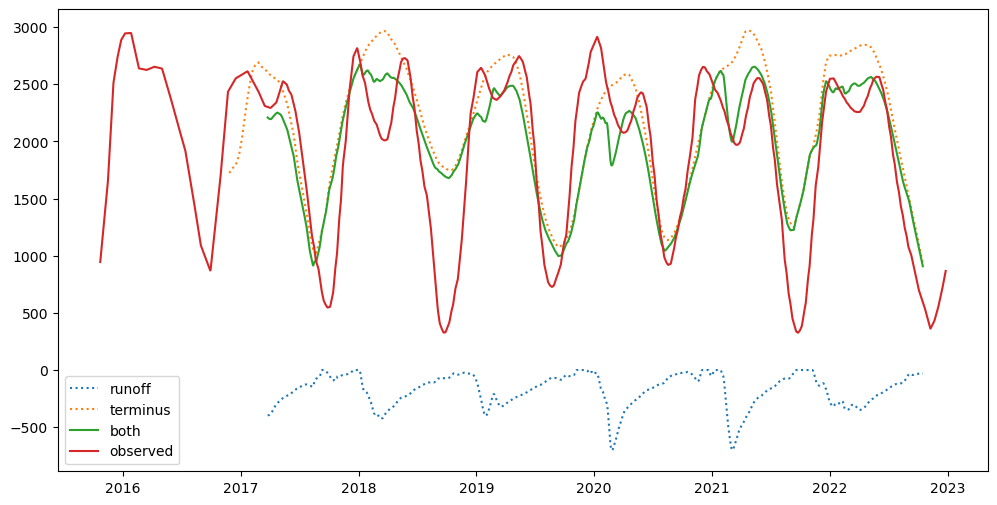

In [272]:
plt.figure(figsize=(12,6))
vr, vterm = vs(res.x, obs)

plt.figure(figsize=(12,6))
plt.plot(obs["time"], vr, ':',label='runoff')
plt.plot(obs["time"], vterm, ':', label='terminus')
plt.plot(obs["time"], vterm+vr, label='both')
plt.plot(obs["time"], obs["v"], label='observed')
plt.legend()